In [1]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import numpy as np
from skimage import color, io
from skimage.io import imsave

In [2]:
tf.set_random_seed(0)
batch_size = 12

In [3]:
def convertToLab(image, original):
    lab = color.rgb2lab(image)
    X_batch = lab[:,:,0]
    Y_batch = lab[:,:,1:]
    return X_batch.reshape(X_batch.shape+(1,)), Y_batch, original

def parseImage(filename):
    original = tf.read_file(filename)
    original = tf.image.decode_jpeg(original, channels=3)
    image = tf.image.resize_images(original, [256, 256], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, original

In [4]:
file_paths = map((lambda x: "../train/" + x), os.listdir("../train/"))

dataset = tf.data.Dataset.from_tensor_slices(file_paths)
dataset = dataset.map(parseImage)
dataset = dataset.map(lambda image, original: 
    tuple(tf.py_func(
        convertToLab, [image, original], [tf.double, tf.double, original.dtype]
    ))
)
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()

In [5]:
def conv2DRelu(X, W, B, strides, padding):
    # strides: [batch_step, height_step, width_step, channel_step] 
    return tf.nn.relu(tf.nn.conv2d(X, W, strides=strides, padding=padding) + B)

def conv2DTanh(X, W, B, strides, padding):
    # strides: [batch_step, height_step, width_step, channel_step] 
    return tf.nn.tanh(tf.nn.conv2d(X, W, strides=strides, padding=padding) + B)

def weight(width, height, input_channels, output_channels):
    # [width, height, input channel, output channel]
    return tf.Variable(tf.truncated_normal([width, height, input_channels, output_channels], stddev=0.1))

def bias(outputChannels):
    return tf.Variable(tf.zeros([outputChannels])) # bias for each output channel.

def upSampling2D(X, height, width):
    return tf.image.resize_images(X, [height, width], tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def upSampleToOriginalSize(X, size):
    return tf.image.resize_images(X, size, tf.image.ResizeMethod.NEAREST_NEIGHBOR)

In [6]:
# The input images x will consist of a 2d tensor of floating point numbers.
#X = tf.placeholder(tf.float32, shape=[None, [256, 256, 1]]) # 256 x 256
# The target output y_ will also consist of a 2d tensor, where each row is 
# a one-hot 2-dimensional vector indicating a b values.
Y_ = tf.placeholder(tf.float32, shape=[None, 256, 256, 2])

# Input Layer
X = tf.placeholder(tf.float32, shape=[None, 256, 256, 1]) # 256 x 256

Size = tf.placeholder(tf.int32, shape=[None])

# Conv layer 1 
W1 = weight(5, 5, 1, 64)
B1 = bias(64)
Y1 = conv2DRelu(X, W1, B1, [1,1,1,1], 'SAME')

# Conv layer 2
W2 = weight(5, 5, 64, 64)
B2 = bias(64)
Y2 = conv2DRelu(Y1, W2, B2, [1, 2, 2, 1], 'SAME')

# Conv layer 3
W3 = weight(5, 5, 64, 128)
B3 = bias(128)
Y3 = conv2DRelu(Y2, W3, B3, [1, 1, 1, 1], 'SAME')

# Conv layer 4
W4 = weight(5, 5, 128, 128)
B4 = bias(128)
Y4 = conv2DRelu(Y3, W4, B4, [1, 2, 2, 1], 'SAME')

# Conv layer 5
W5 = weight(5, 5, 128, 256)
B5 = bias(256)
Y5 = conv2DRelu(Y4, W5, B5, [1, 1, 1, 1], 'SAME')

# Conv layer 6
W6 = weight(5, 5, 256, 256)
B6 = bias(256)
Y6 = conv2DRelu(Y5, W6, B6, [1, 2, 2, 1], 'SAME')

# Conv layer 7
W7 = weight(5, 5, 256, 512)
B7 = bias(512)
Y7 = conv2DRelu(Y6, W7, B7, [1, 1, 1, 1], 'SAME')

# Conv layer 8
W8 = weight(5, 5, 512, 256)
B8 = bias(256)
Y8 = conv2DRelu(Y7, W8, B8, [1, 1, 1, 1], 'SAME')

# Conv layer 9
W9 = weight(5, 5, 256, 128)
B9 = bias(128)
Y9 = conv2DRelu(Y8, W9, B9, [1, 1, 1, 1], 'SAME')

# Up sampling layer 1
Y10 = upSampling2D(Y9, 64, 64)

# Conv layer 10
W11 = weight(5, 5, 128, 64)
B11 = bias(64)
Y11 = conv2DRelu(Y10, W11, B11, [1, 1, 1, 1], 'SAME')

# Up sampling layer 2
Y12 = upSampling2D(Y11, 128, 128)

# Conv layer 11
W13 = weight(5, 5, 64, 32)
B13 = bias(32)
Y13 = conv2DRelu(Y12, W13, B13, [1, 1, 1, 1], 'SAME')

# Conv layer 12
W14 = weight(5, 5, 32, 2)
B14 = bias(2)
Y14 = conv2DTanh(Y13, W14, B14, [1, 1, 1, 1], 'SAME')

# Up sampling layer 3
Y15 = tf.multiply(upSampling2D(Y14, 256, 256), 128)

# Resize to Original size
Y16 = upSampleToOriginalSize(Y15, Size)

# Define the loss function 
loss = tf.reduce_mean(tf.squared_difference(Y15, Y_), 1) 

# Define an optimizer
optimizer = tf.train.RMSPropOptimizer(0.001).minimize(loss)

In [7]:
saver = tf.train.Saver()

In [8]:
init = tf.global_variables_initializer()
next_element = iterator.get_next()

with tf.Session() as sess:
  
    # initialize the variables
    sess.run(init)

    # initialize the queue threads to start to shovel data
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    print "from the train set:"
    # images, labels = iterator.get_next()
    step = 0
    while True:
        
        try:
            elem = sess.run(next_element)
            _, height, width, _ = elem[2].shape
            print "Step:", step
            _, luss , _ = sess.run([optimizer, loss, Y16], feed_dict={
                X: elem[0], Y_: elem[1], Size: [height, width]
            })
            print "Loss:", luss
            #saver.save(sess, './model/' + 'model.ckpt', global_step=step+1)
            step += 1
            if step == 5:
                saver.save(sess, './model/' + 'model.ckpt', global_step=step+1)
                break
        except tf.errors.OutOfRangeError:
            saver.save(sess, './model/' + 'model.ckpt', global_step=step+1)
            print("End of training dataset.")
            break
            
    # stop our queue threads and properly close the session
    coord.request_stop()
    coord.join(threads)
    sess.close()

from the train set:
Step: 0
Loss: [[[ 16201.16015625  15795.921875  ]
  [ 16231.18066406  15744.88671875]
  [ 16240.98242188  15675.72753906]
  ..., 
  [ 15708.44921875  14603.48535156]
  [ 17425.68164062  14632.828125  ]
  [ 17409.5625      14621.97460938]]

 [[ 17990.29492188  15400.27246094]
  [ 18147.71289062  15345.5625    ]
  [ 18419.47070312  15346.359375  ]
  ..., 
  [ 18654.33789062  15569.71191406]
  [ 14636.5390625   15491.09375   ]
  [ 14564.17871094  15398.38867188]]

 [[ 14128.82617188  12826.68261719]
  [ 14169.26953125  12779.41992188]
  [ 14206.80078125  12738.88769531]
  ..., 
  [ 14861.12402344  15635.76171875]
  [ 18253.8046875   15796.96777344]
  [ 18237.671875    15759.57324219]]

 ..., 
 [[ 17156.60546875  16282.44140625]
  [ 17209.71875     16253.11230469]
  [ 17230.56640625  16285.43457031]
  ..., 
  [ 16443.93164062  15391.33398438]
  [ 16551.79296875  15278.40722656]
  [ 16521.61328125  15239.71484375]]

 [[ 15914.43359375  13859.74804688]
  [ 16013.0546875  

In [9]:
file_test_paths = ['../data/img_13.jpg'] # map((lambda x: "../data/" + x), os.listdir("../data/"))

testDataset = tf.data.Dataset.from_tensor_slices(file_test_paths)
testDataset = testDataset.map(parseImage)
testDataset = testDataset.map(lambda image, original: 
    tuple(tf.py_func(
        convertToLab, [image, original], [tf.double, tf.double, original.dtype]
    ))
)
testDataset = testDataset.batch(1)

testIterator = testDataset.make_one_shot_iterator()

In [10]:
def plotImage(image):
    #plt.imshow(image)
    plt.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    
    plt.show()

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-6


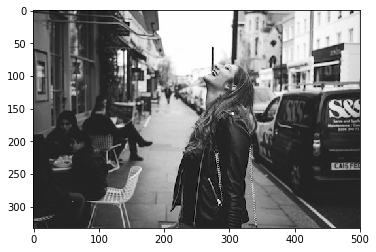

/usr/local/lib/python2.7/dist-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 113086 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


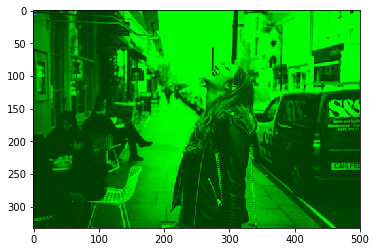

SAVING IMAGE


/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


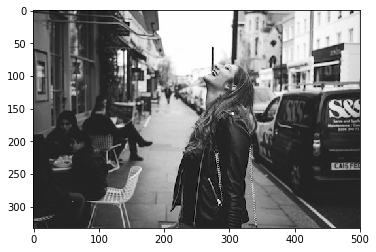

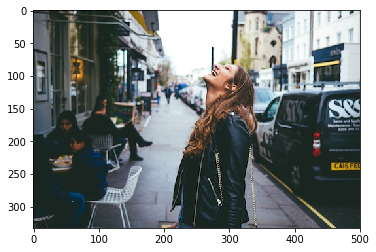

In [11]:
next_element = testIterator.get_next()
with tf.Session() as session:
    elem = session.run(next_element)
    _, height, width, _ = elem[2].shape # Original size of image
    ckpt = tf.train.get_checkpoint_state('./model/')
    saver.restore(session, ckpt.model_checkpoint_path)
    feed_dict = {X: elem[0], Y_: elem[1], Size: [height, width]}
    _, ab = session.run([optimizer, Y16], feed_dict)
    
    # Colorize output
    ab = ab
    
    
    grey_scale = color.rgb2lab(elem[2])
    
    predict_bw = np.zeros((height, width, 3))
    predict_bw[:,:,0] = grey_scale[0][:,:,0]
    #print bwImg
    predict_bw = color.lab2rgb(predict_bw)
    #print colored
    plotImage(predict_bw)
    
    
    colored = np.zeros((height, width, 3))
    colored[:,:,0] = grey_scale[0][:,:,0]
    colored[:,:,1:] = ab[0]
    
    colored_rgb = color.lab2rgb(colored)
    
    plotImage(colored_rgb)
    
    print "SAVING IMAGE"
    imsave("../result/img_yolo.png", colored_rgb)
    
    
    # Original Picture
    original_lab = color.rgb2lab(elem[2])
    
    original_bw = np.zeros((height, width, 3))
    original_bw[:,:,0] = original_lab[0][:,:,0]
    
    plotImage(color.lab2rgb(original_bw))
    plotImage(elem[2][0])